In [27]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [28]:
print(device)

cpu


In [29]:
data_path = './data'

splitProp = 0.8

In [30]:
def loadDataset(): #Function to parse through the directory and append the required images and their labels
    imgs = []
    labels = []
    label = -1
    
    directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    
    for directory in directories:
        label = label + 1
        path = data_path+'/'+directory
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        
        for file in files:
            imgPath = path+'/'+file
            imgs.append(imgPath)
            labels.append(label)
    
    return (imgs,labels)

In [31]:
dataset = loadDataset()

In [32]:
trainImgPaths,testImgPaths, Y_train, Y_test = train_test_split(dataset[0], dataset[1], 
                                                train_size=splitProp, random_state=42,shuffle = True,stratify = dataset[1])

0


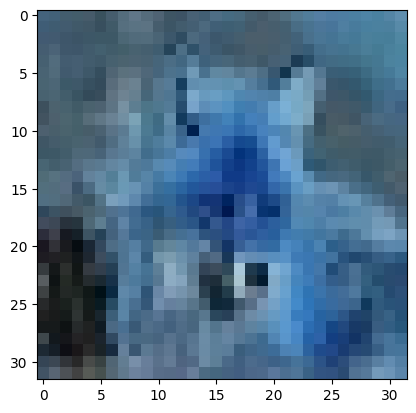

In [33]:
img=cv2.imread(trainImgPaths[1700])
print(Y_train[1700])
plt.imshow(img)
plt.show()

In [34]:
def getImages(imgsPath):
    imgs = []
    for imgName in imgsPath:
        img = cv2.imread(imgName)
        imgs.append(img)
    imgs = np.asarray(imgs,dtype=object)
    return imgs

In [35]:
X_train = getImages(trainImgPaths)
X_test = getImages(testImgPaths)

In [36]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = torch.from_numpy(X_train.astype('int32'))
X_test = torch.from_numpy(X_test.astype('int32'))


In [37]:
Y_train = torch.tensor(Y_train)
Y_test = torch.tensor(Y_test)

In [38]:
print('Training data dimensions : {}\n'.format(X_train.shape))
print('Training data dimensions : {}\n'.format(Y_train.shape))
print('Validation data dimensions : {}\n'.format(X_test.shape))
print('Validation data dimensions : {}\n'.format(Y_test.shape))

Training data dimensions : torch.Size([2200, 32, 32, 3])

Training data dimensions : torch.Size([2200])

Validation data dimensions : torch.Size([551, 32, 32, 3])

Validation data dimensions : torch.Size([551])



In [39]:
def visualize_item(ix):
    img = X_train[ix]
    label = Y_train[ix]
    plt.imshow(img)
    plt.title('Class Label : '+str(label.numpy()))
    plt.show()

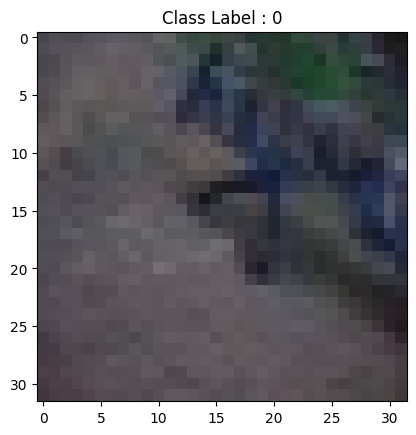

In [40]:
visualize_item(29)


In [41]:
X_train = X_train.float()
X_test = X_test.float()

In [42]:
class DogFox(Dataset):
    def __init__(self, x, y):
        x = x.float()/255   
        x = x.view(-1,32*32*3)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [43]:
def get_data(batch_size): 
    train = DogFox(X_train,Y_train) 
    trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    return trn_dl

train_loader = get_data(batch_size=32)


In [44]:
from torch.optim import SGD
import torch.optim as optim
def get_model():
    model = nn.Sequential(
                nn.Linear(32 * 32 *3, 1000),
                nn.ReLU(),
                nn.Linear(1000, 2)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=0.005)

    return model, loss_fn, optimizer

In [45]:

def train_batch(x, y, model, opt, loss_fn):
    model.train() 
    prediction = model(x) 
    batch_loss = loss_fn(prediction, y)  # compute loss
    
    batch_loss.backward()  
    
    opt.step()
    
    opt.zero_grad()  
    return batch_loss.item()

In [46]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() 
    prediction = model(x)   
    
    max_values, argmaxes = prediction.max(-1)  
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


Epoch : 0 : loss : 18.64092528831891 
Epoch : 1 : loss : 0.6608937548304146 
Epoch : 2 : loss : 0.4894954713908109 
Epoch : 3 : loss : 0.539627422968095 
Epoch : 4 : loss : 0.5144080696796829 
Epoch : 5 : loss : 0.44180556017566813 
Epoch : 6 : loss : 0.4441640681502494 
Epoch : 7 : loss : 0.3985221727327867 
Epoch : 8 : loss : 0.41280174986882645 
Epoch : 9 : loss : 0.39995042136446995 


/tmp/ipykernel_44398/2918188296.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


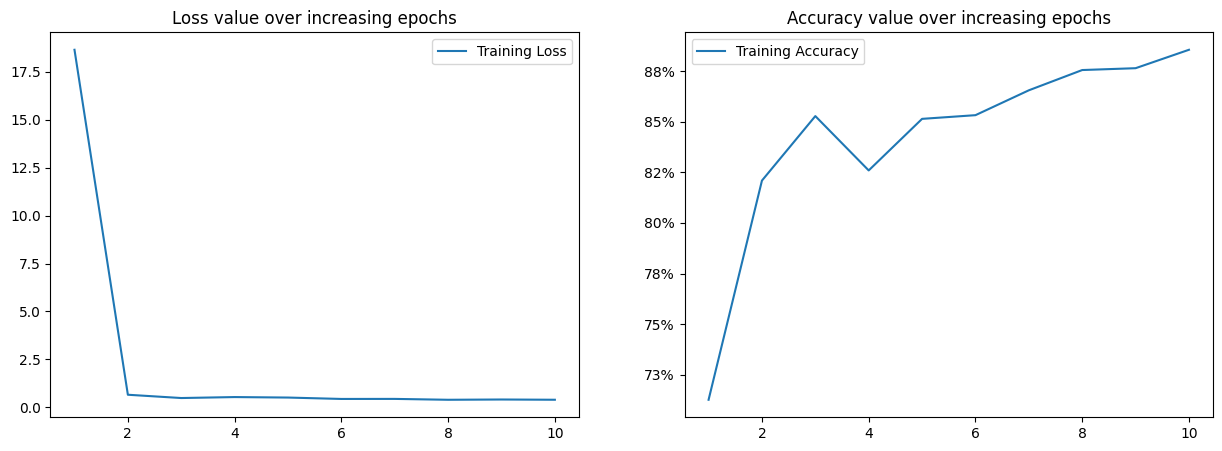

In [47]:
train_loader =get_data(batch_size=10)
model, loss_fn, optimizer = get_model()

losses,accuracies=[], []

n_epochs=10
for epoch in range(n_epochs):
    epoch_losses,epoch_accuracies = [],[]
    for index,batch in enumerate(iter(train_loader)):
        x,y= batch
        batch_loss=train_batch(x=x,y=y, model=model, loss_fn=loss_fn, opt=optimizer)
        epoch_losses.append(batch_loss)
        is_correct= accuracy(x,y, model)
        epoch_accuracies.append(is_correct)
    epoch_loss= np.array(epoch_losses).mean()
    epoch_accuracy= np.array(epoch_accuracies).mean()
    losses.append(epoch_loss)
    print('Epoch : {epoch} : loss : {loss} '.format(epoch=epoch,loss=epoch_loss))
    accuracies.append(epoch_accuracy)
    
epochs= np.arange(n_epochs)+1
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()]) 
plt.legend()
    


In [48]:

def get_data(batch_size): 
    train = DogFox(X_train,Y_train) 
    trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val = DogFox(X_test, Y_test) 
    val_dl = DataLoader(val, batch_size=len(X_test), shuffle=False)
    return trn_dl, val_dl



@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [49]:
train_loader, val_loader = get_data(batch_size=32)
model, loss_fn, optimizer = get_model()
     
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(n_epochs):
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_loader)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

/home/chinmay/.local/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


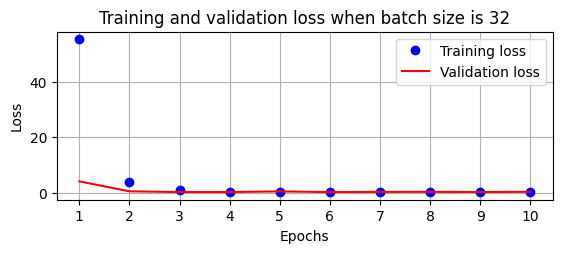

/tmp/ipykernel_44398/1298463582.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


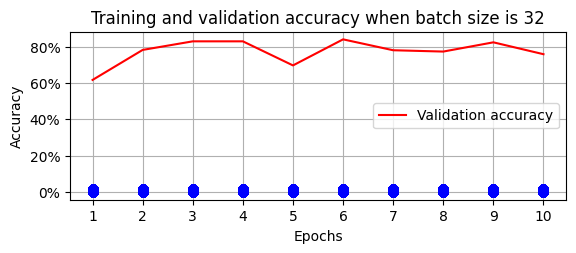

In [50]:


epochs = np.arange(n_epochs)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()
     


In [51]:
print(val_accuracies[-1])

0.7586206896551724
